In [176]:
import pandas as pd
import os
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [177]:
connection = sqlite3.connect('data/general.db')

tables = ['athletes', 'coaches', 'events', 'medallists', 'medals', 'medals_total',
    'nocs', 'schedules', 'schedules_preliminary', 'teams', 'technical_officials',
    'torch_route', 'venues']


#### Lets Load data from each table into a dictionary of DataFrames


In [178]:
data = {}
for table in tables:
    data[table] = pd.read_sql_query(f"SELECT * FROM {table}", connection)
connection.close()

#### Iterating over each tables to get the top 5 result from each table

In [179]:
for table, df in data.items():
    print(f"Table: {table}")
    print(df.head(),)

Table: athletes
      code current               name     name_short            name_tv  \
0  1532872    True   ALEKSANYAN Artur   ALEKSANYAN A   Artur ALEKSANYAN   
1  1532873    True     AMOYAN Malkhas       AMOYAN M     Malkhas AMOYAN   
2  1532874    True    GALSTYAN Slavik     GALSTYAN S    Slavik GALSTYAN   
3  1532944    True  HARUTYUNYAN Arsen  HARUTYUNYAN A  Arsen HARUTYUNYAN   
4  1532945    True    TEVANYAN Vazgen     TEVANYAN V    Vazgen TEVANYAN   

  gender function country_code  country country_long  ...  \
0   Male  Athlete          ARM  Armenia      Armenia  ...   
1   Male  Athlete          ARM  Armenia      Armenia  ...   
2   Male  Athlete          ARM  Armenia      Armenia  ...   
3   Male  Athlete          ARM  Armenia      Armenia  ...   
4   Male  Athlete          ARM  Armenia      Armenia  ...   

                                              family  \
0                          Father, Gevorg Aleksanyan   
1                                                     

#### Lets check for the null values

In [180]:
for table, df in data.items():
    print(f"cleaning table:{table}")

    print(df.isnull().sum())


#nothing found we are good

cleaning table:athletes
code                  0
current               0
name                  0
name_short            0
name_tv               0
gender                0
function              0
country_code          0
country               0
country_long          0
nationality           0
nationality_long      0
nationality_code      0
height                0
weight                0
disciplines           0
events                0
birth_date            0
birth_place           0
birth_country         0
residence_place       0
residence_country     0
nickname              0
hobbies               0
occupation            0
education             0
family                0
lang                  0
coach                 0
reason                0
hero                  0
influence             0
philosophy            0
sporting_relatives    0
ritual                0
other_sports          0
dtype: int64
cleaning table:coaches
code            0
current         0
name            0
gender          0
func

#### Converting all date columns to datetime type

In [181]:
if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])

#### Top 50 Countries with Athletes

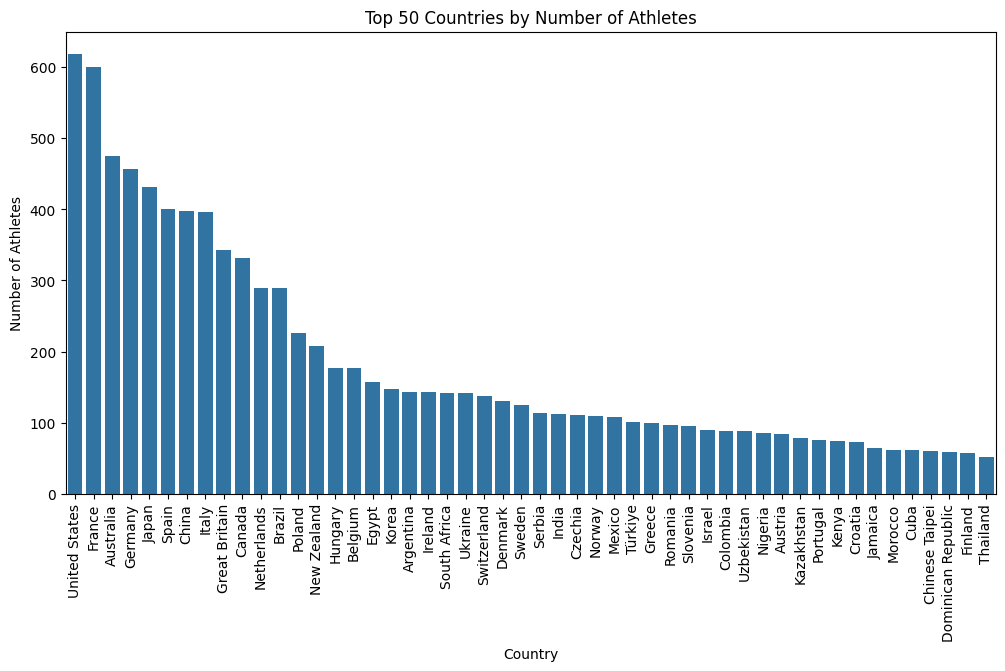

In [182]:
# Top 50 countries by number of athletes
top_50_countries = data['athletes']['country'].value_counts().nlargest(50)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_50_countries.index, y=top_50_countries.values)
plt.title('Top 50 Countries by Number of Athletes')
plt.xlabel('Country')
plt.ylabel('Number of Athletes')
plt.xticks(rotation=90)
plt.show()

In [183]:
# Calculated age from birth_date as there was birth_date cloumn instead of 'age'
current_year = datetime.now().year
data['athletes']['birth_date'] = pd.to_datetime(data['athletes']['birth_date'])
data['athletes']['age'] = current_year - data['athletes']['birth_date'].dt.year

In [184]:
# If birth_date is not recorded in table
data['athletes']['age'] = data['athletes']['age'].fillna(0).astype(int)

#### Atheletes by Age

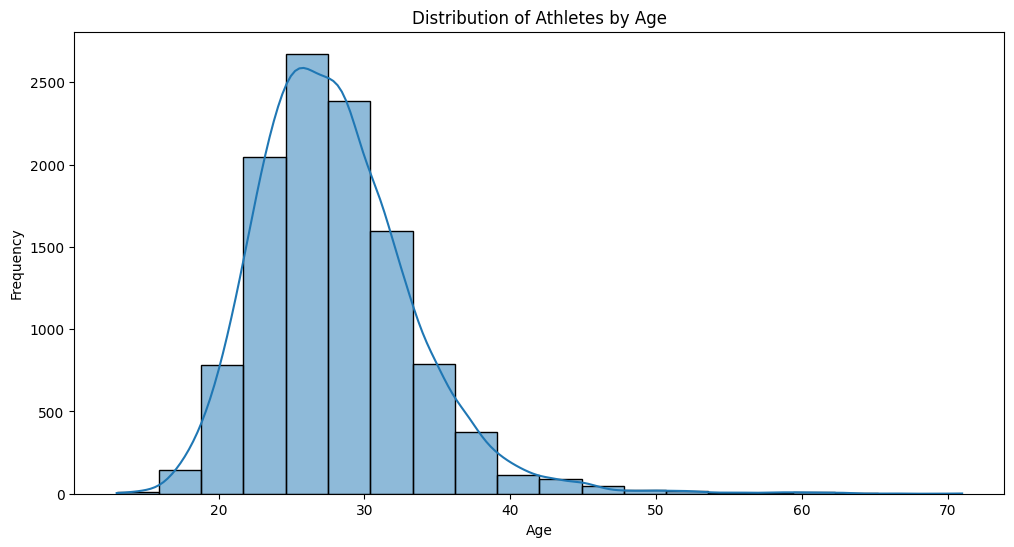

In [185]:
plt.figure(figsize=(12, 6))
sns.histplot(data['athletes']['age'], bins=20, kde=True)
plt.title('Distribution of Athletes by Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


In [186]:
# Counted unique athletes by 'name'
unique_athletes_count = data['athletes']['name'].nunique()
print(f"Number of unique athletes: {unique_athletes_count}")

Number of unique athletes: 11103


#### Male VS Female

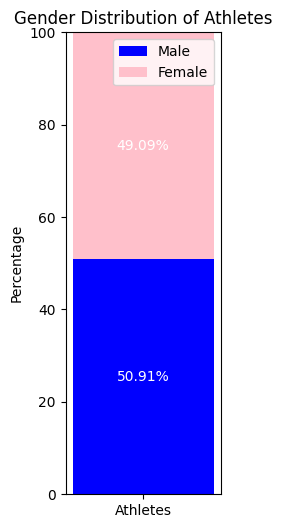

In [187]:
# Calculate gender percentages
gender_counts = data['athletes']['gender'].value_counts(normalize=True) * 100
gender_percentages = gender_counts.to_dict()

labels = ['Athletes']
male_percentage = gender_percentages.get('Male', 0)
female_percentage = gender_percentages.get('Female', 0)
values = [male_percentage, female_percentage]

fig, ax = plt.subplots(figsize=(2, 6))

# Plotted the stacked bar chart
ax.bar(labels, male_percentage, label='Male', color='blue')
ax.bar(labels, female_percentage, bottom=male_percentage, label='Female', color='pink')

# Added percentage labels
for i, v in enumerate(values):
    ax.text(0, sum(values[:i+1]) - v/2, f"{v:.2f}%", color='white', ha='center', va='center')

ax.set_title('Gender Distribution of Athletes')
ax.set_ylabel('Percentage')
ax.set_ylim(0, 100) 
ax.legend()

plt.show()

In [188]:
data['athletes']['height'] = pd.to_numeric(data['athletes']['height'], errors='coerce')

In [189]:
filtered_athletes = data['athletes'][data['athletes']['height'] >= 100]

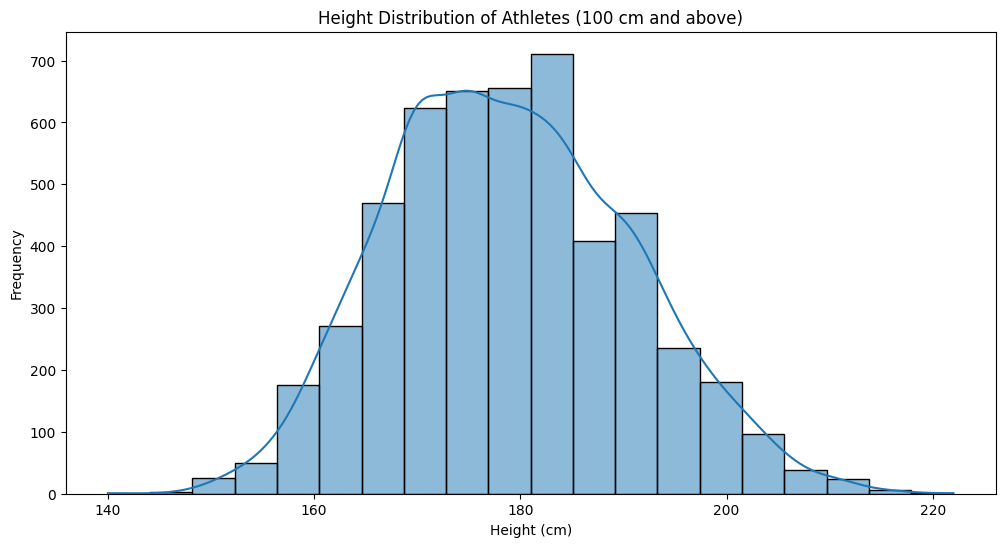

In [190]:
# Height distribution for heights 100 cm and above
plt.figure(figsize=(12, 6))
sns.histplot(filtered_athletes['height'].dropna(), bins=20, kde=True)
plt.title('Height Distribution of Athletes (100 cm and above)')
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')
plt.show()

In [191]:
# Droped records where either 'birth_country' or 'country' is missing
cleaned_athletes = data['athletes'].dropna(subset=['birth_country', 'country'])

In [192]:
# Counted the number of players born in each country
birth_country_counts = cleaned_athletes['birth_country'].value_counts()

In [193]:
# Counted the number of players representing each country
representing_country_counts = cleaned_athletes['country'].value_counts()

In [194]:
# Combined the counts into a single DataFrame
country_comparison = pd.DataFrame({
    'Born': birth_country_counts,
    'Representing': representing_country_counts
}).fillna(0)

In [195]:
# Calculated the total number of players for each country
country_comparison['Total'] = country_comparison['Born'] + country_comparison['Representing']

# Selected the top 50 countries based on the total number of players
top_50_countries = country_comparison.nlargest(50, 'Total')

#### Number of Players Born in Country vs. Representing thier playing Country

<Figure size 2000x1000 with 0 Axes>

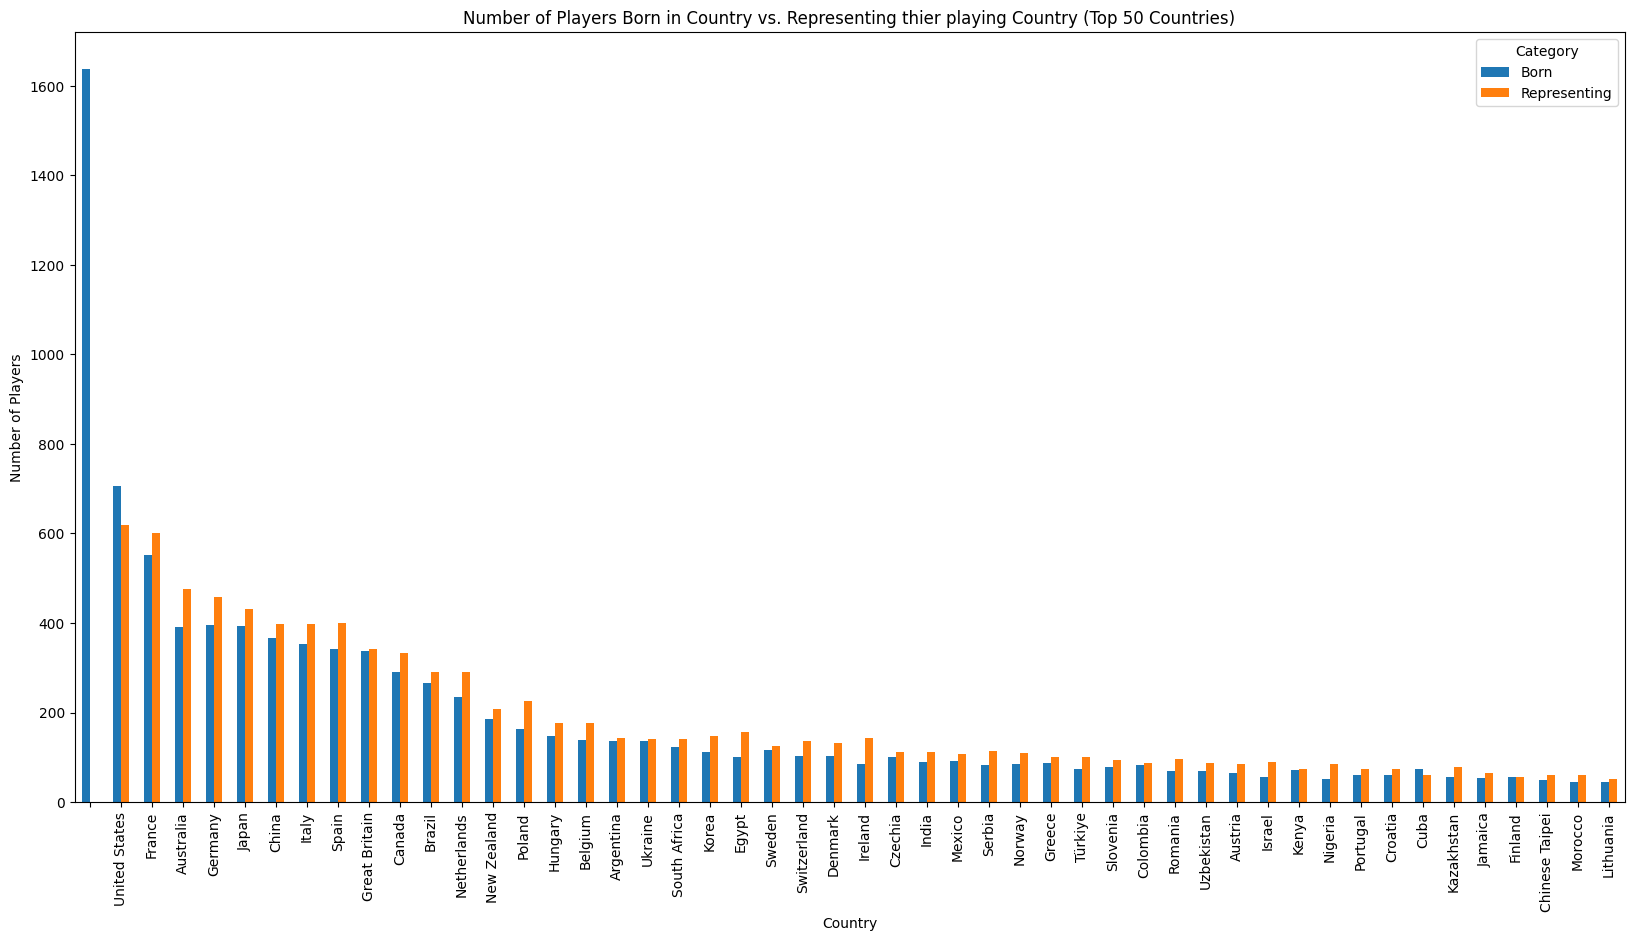

In [196]:
# Ploted the grouped bar chart
plt.figure(figsize=(20, 10))
top_50_countries[['Born', 'Representing']].plot(kind='bar', stacked=False, figsize=(20, 10))
plt.title('Number of Players Born in Country vs. Representing thier playing Country (Top 50 Countries)')
plt.xlabel('Country')
plt.ylabel('Number of Players')
plt.xticks(rotation=90)
plt.legend(title='Category')
plt.show()

#### Male vs Female by country

<Figure size 5000x2000 with 0 Axes>

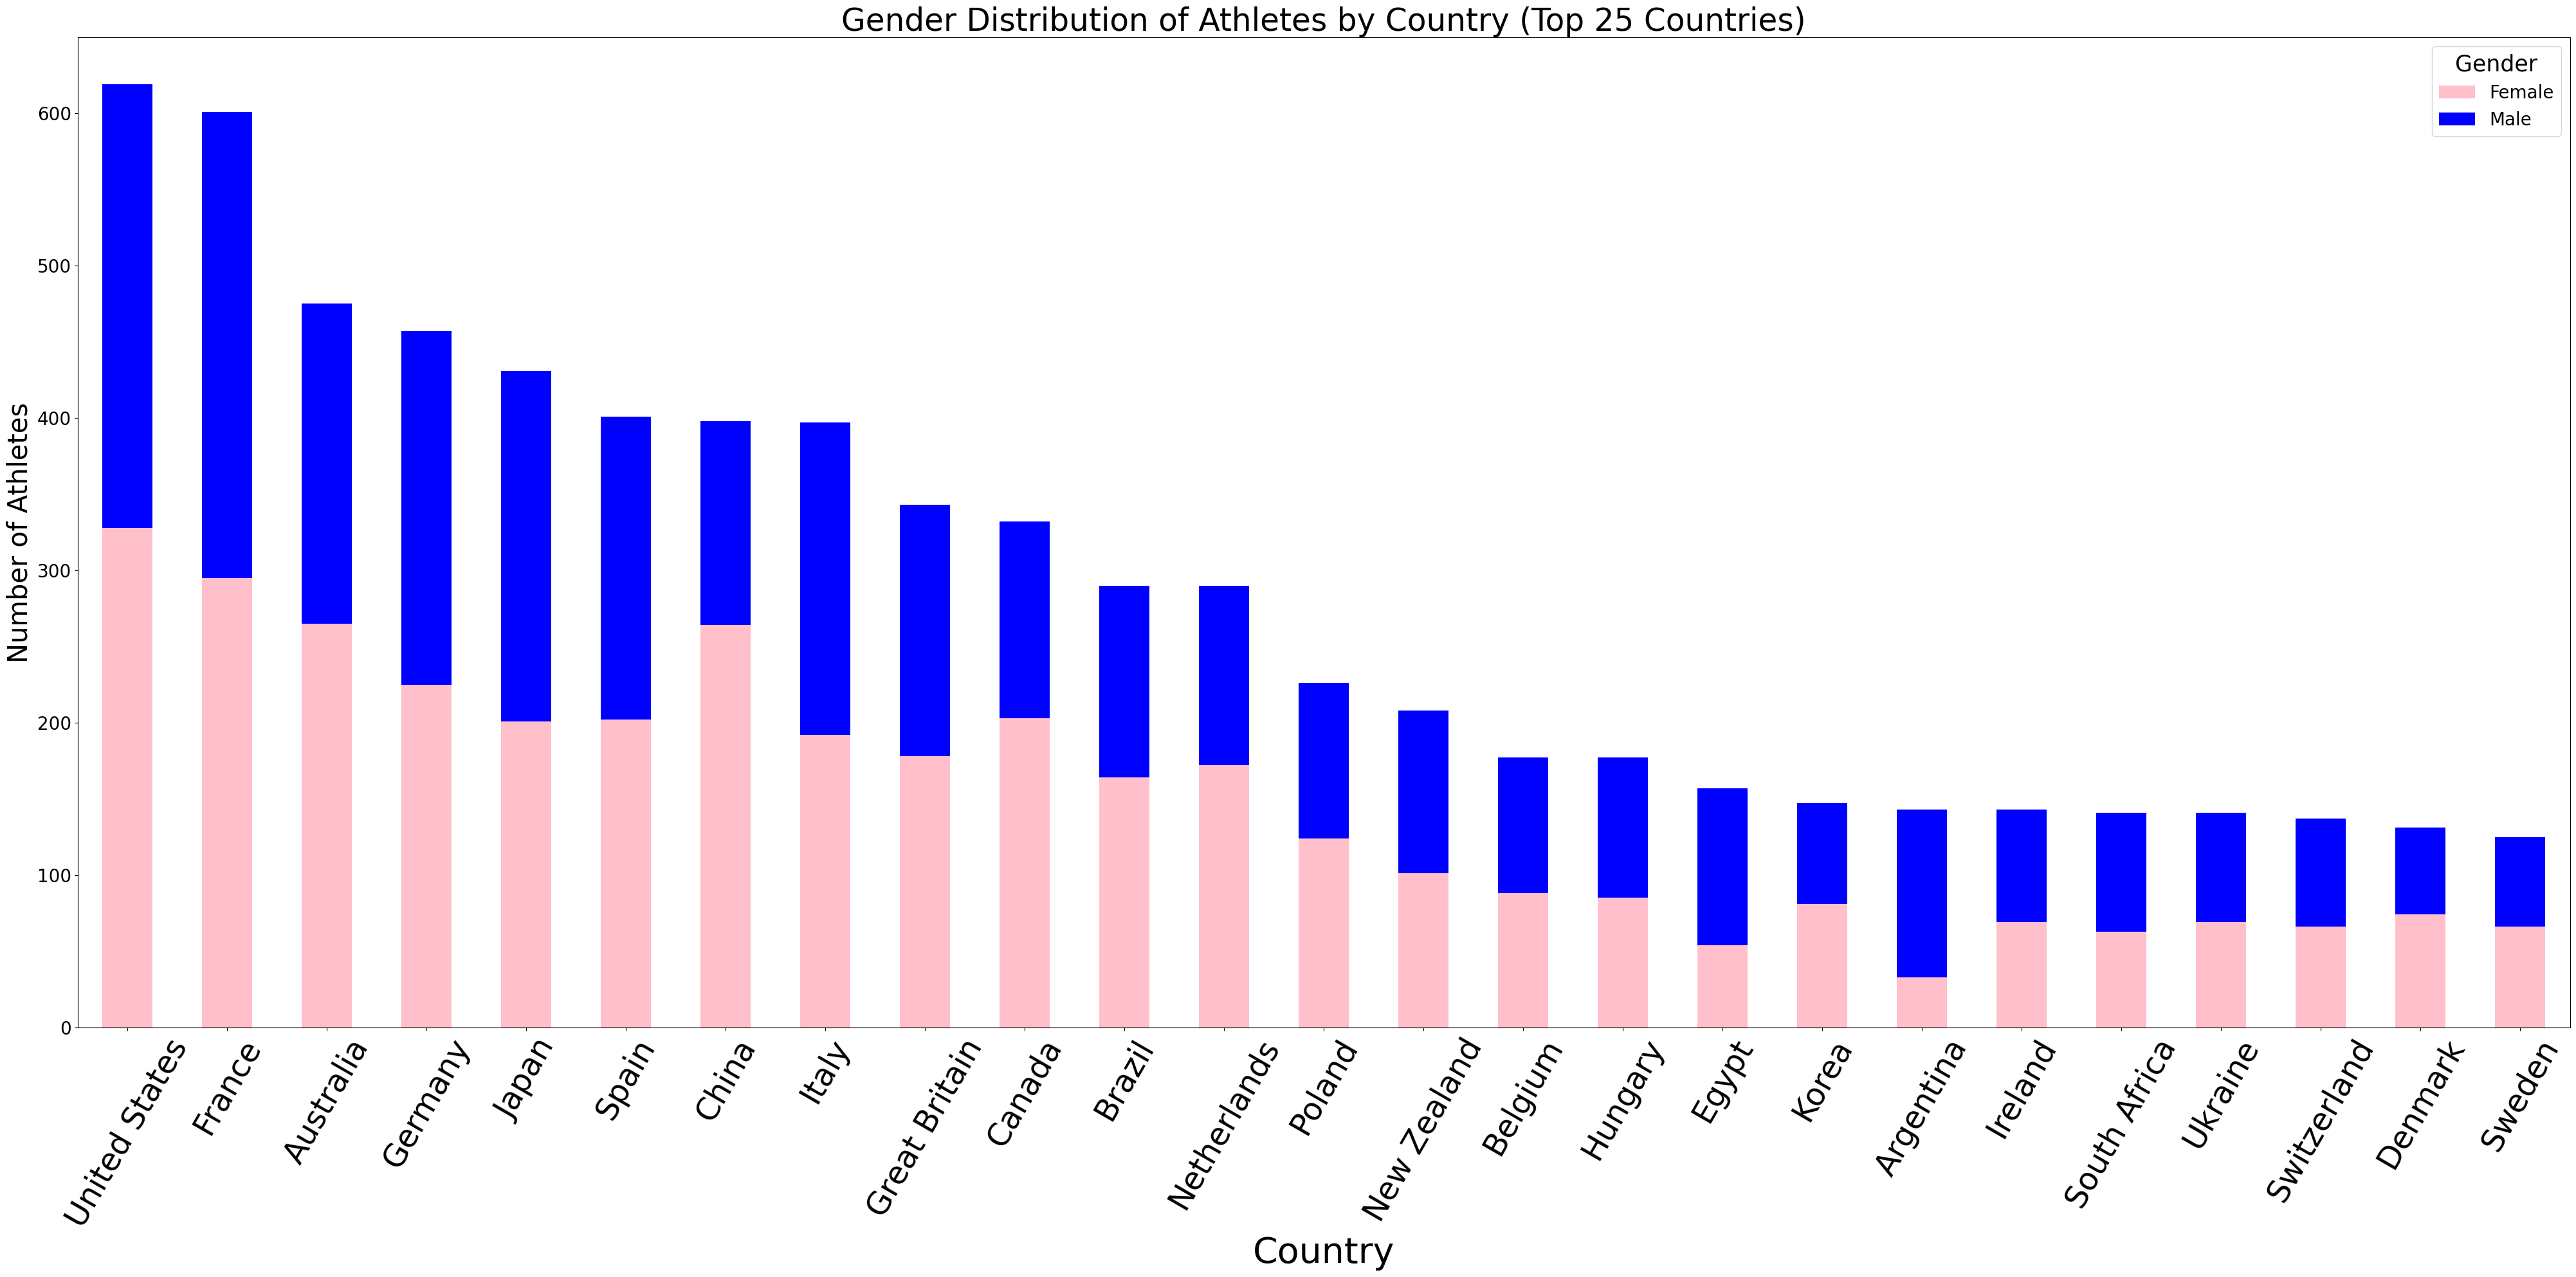

In [197]:
# Counted the number of male and female athletes representing each country
gender_country_counts = cleaned_athletes.groupby(['country', 'gender']).size().unstack(fill_value=0)

# Selected the top 25 countries based on the total number of athletes
top_25_countries_gender = gender_country_counts.sum(axis=1).nlargest(25).index
top_25_gender_country_counts = gender_country_counts.loc[top_25_countries_gender]

# Ploted the grouped bar chart
plt.figure(figsize=(50, 20))
top_25_gender_country_counts.plot(kind='bar', stacked=True, figsize=(50, 20), color=['pink', 'blue'])
plt.title('Gender Distribution of Athletes by Country (Top 25 Countries)', fontsize=35)
plt.xlabel('Country', fontsize=40)
plt.ylabel('Number of Athletes', fontsize=30)
plt.xticks(rotation=60, fontsize=35)
plt.yticks(fontsize=20)
plt.legend(title='Gender', fontsize=20, title_fontsize=25)
plt.show()

In [198]:
# removed the brackets error
cleaned_athletes['disciplines'] = cleaned_athletes['disciplines'].apply(lambda x: x.strip("[]").replace("'", ""))

#### Disciplines with most number of Athletes

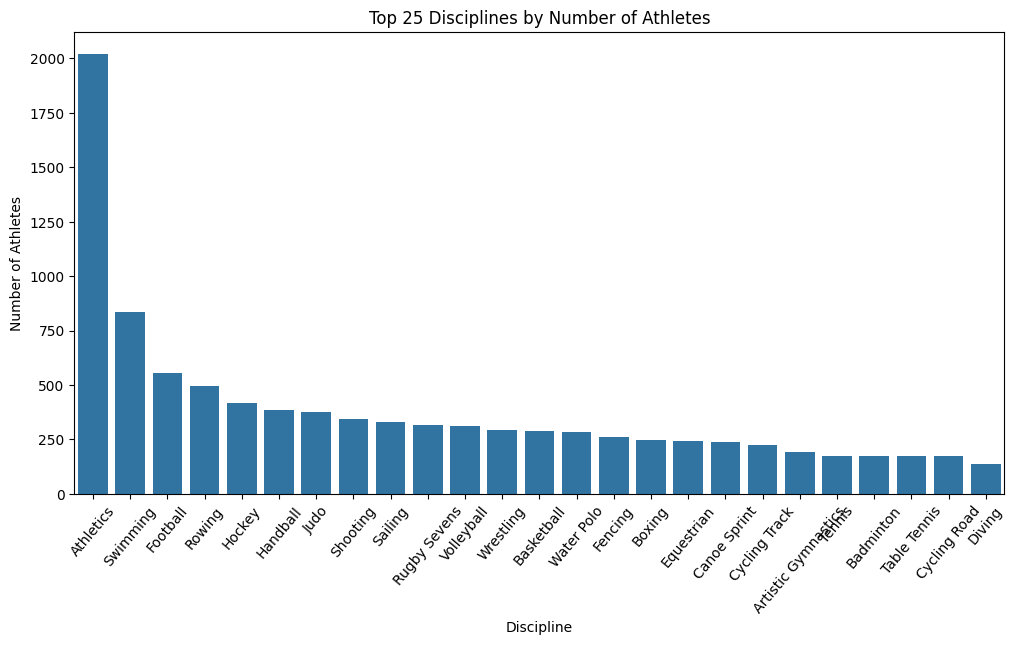

In [199]:
# Counted the number of athletes in each discipline
discipline_counts = cleaned_athletes['disciplines'].value_counts()

# Selected the top 10 disciplines
top_25_disciplines = discipline_counts.nlargest(25)

# Ploted the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_25_disciplines.index, y=top_25_disciplines.values)
plt.title('Top 25 Disciplines by Number of Athletes')
plt.xlabel('Discipline')
plt.ylabel('Number of Athletes')
plt.xticks(rotation=50, fontsize=10)
plt.show()

In [200]:
# Joined athletes and medallists tables on 'country_code'
athletes_medallists = pd.merge(data['athletes'], data['medallists'], on='country_code', how='inner')

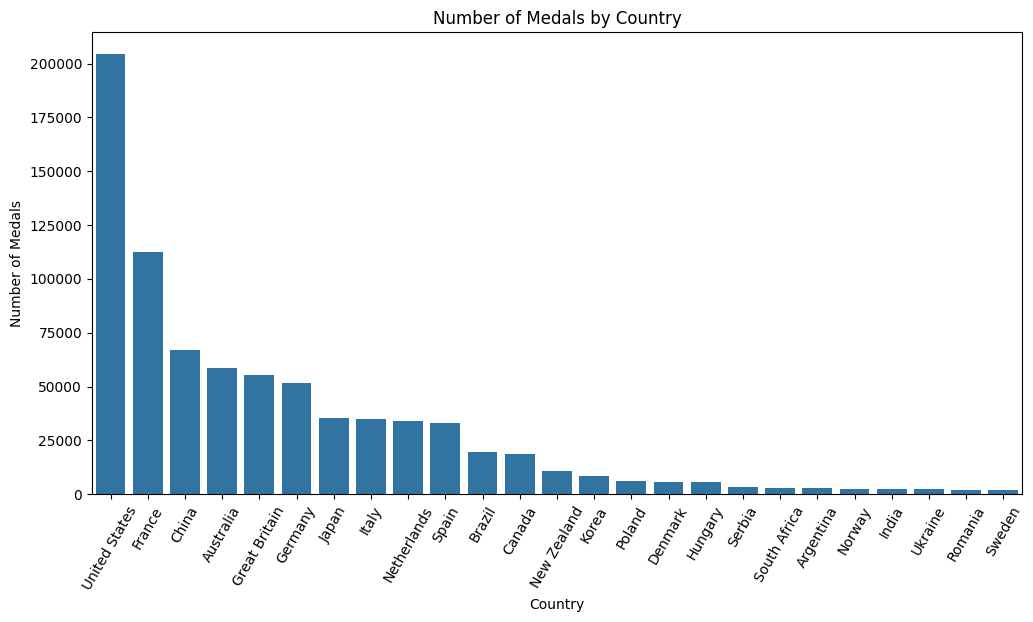

In [201]:
# Counted the number of medals by country
medals_by_country = athletes_medallists['country_x'].value_counts()

top_25_mdl_countries = medals_by_country.nlargest(25)
# Ploted the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=top_25_mdl_countries.index, y=top_25_mdl_countries.values)
plt.title('Number of Medals by Country')
plt.xlabel('Country')
plt.ylabel('Number of Medals')
plt.xticks(rotation=60)
plt.show()

In [202]:
connection = sqlite3.connect('data/general.db')

try:
    # Load data from the 'athletes' and 'medallists' tables into DataFrames
    athletes_df = pd.read_sql_query("SELECT * FROM athletes", connection)
    medallists_df = pd.read_sql_query("SELECT * FROM medallists", connection)
    medals_df = pd.read_sql_query("SELECT * FROM medals", connection)

finally:
    # Close the connection
    connection.close()

In [203]:
# Joined athletes and medallists tables on 'code' and 'code_athlete'
athletes_medallists = pd.merge(athletes_df, medallists_df, left_on='code', right_on='code_athlete', how='inner')

In [204]:
# Counted the number of medals for each athlete
medals_by_athlete = athletes_medallists.groupby('name_x').size().reset_index(name='medal_count')

# Sorted the athletes by the number of medals in descending order
top_athletes = medals_by_athlete.sort_values(by='medal_count', ascending=False).head(20)

/var/folders/k8/lq3sh67104n34dn13hr52z8w0000gn/T/ipykernel_92924/772480446.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='medal_count', y='name_x', data=top_athletes, palette='viridis')


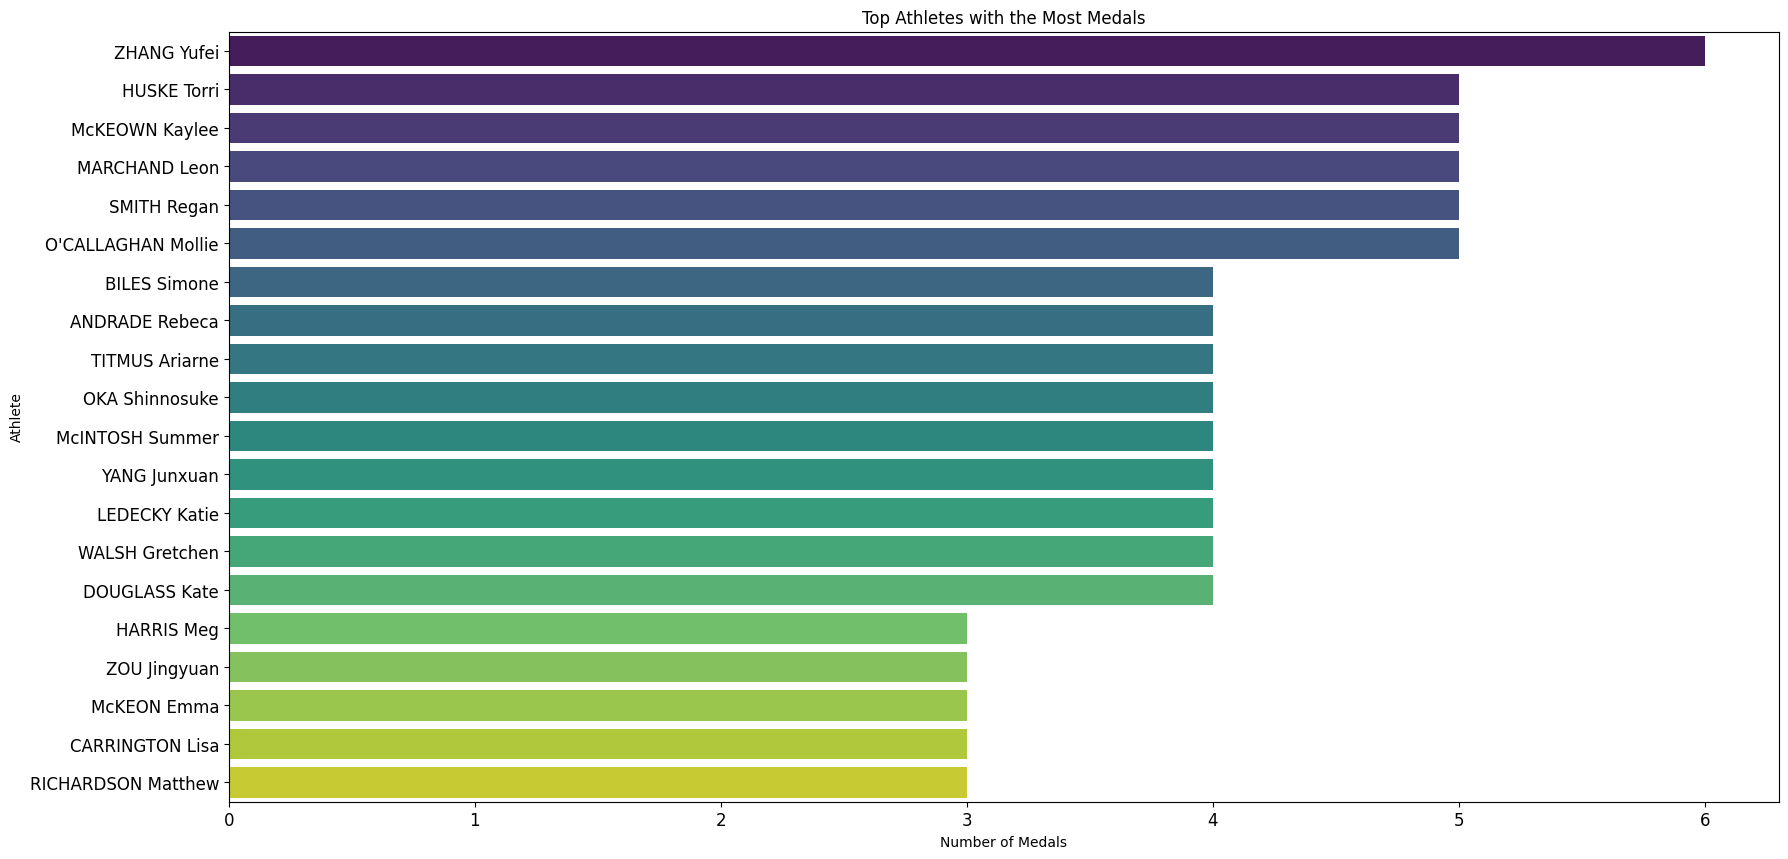

In [205]:
# Ploted the bar chart
plt.figure(figsize=(20, 10))
sns.barplot(x='medal_count', y='name_x', data=top_athletes, palette='viridis')
plt.title('Top Athletes with the Most Medals')
plt.xlabel('Number of Medals')
plt.ylabel('Athlete')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [206]:
connection = sqlite3.connect('data/general.db')

try:
    # Loaded data from the 'schedules' table into a DataFrame
    schedules_df = pd.read_sql_query("SELECT * FROM schedules", connection)
finally:
    # Closed the connection
    connection.close()

In [207]:
# Counted the number of events by location_description and location_code
events_by_location = schedules_df.groupby(['location_description', 'location_code']).size().reset_index(name='event_count')

# Sorted the locations by the number of events in descending order
top_locations = events_by_location.sort_values(by='event_count', ascending=False).head(10)

/var/folders/k8/lq3sh67104n34dn13hr52z8w0000gn/T/ipykernel_92924/978349815.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='event_count', y='location_description', data=top_locations, palette='viridis')


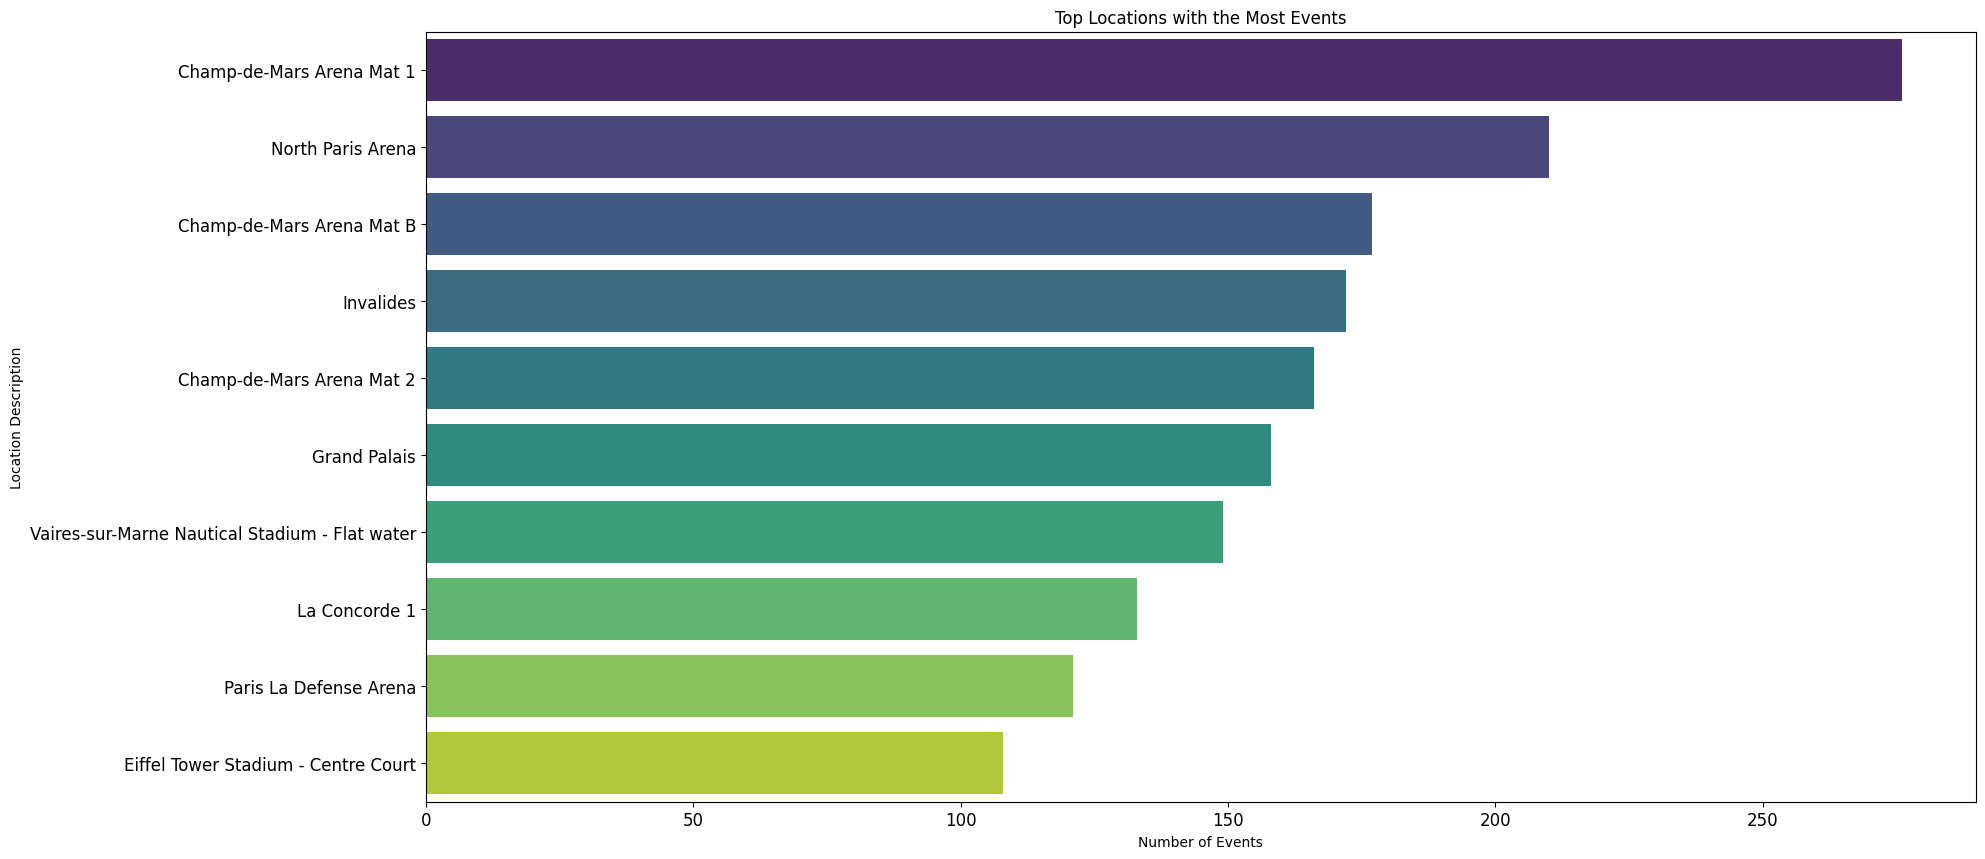

In [208]:
plt.figure(figsize=(20, 10))
sns.barplot(x='event_count', y='location_description', data=top_locations, palette='viridis')
plt.title('Top Locations with the Most Events')
plt.xlabel('Number of Events')
plt.ylabel('Location Description')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# there can be multiple events at same time in a particular place, or 
# event may occur simultaneously at different venues at same time

In [209]:
# Counted the number of each type of medal for each country
medals_by_country = medals_df.groupby(['country_code', 'medal_type']).size().reset_index(name='medal_count')

# Pivot the table to have medal types as columns
medals_pivot = medals_by_country.pivot(index='country_code', columns='medal_type', values='medal_count').fillna(0)

# Reset the index to make 'country_code' a column again
medals_pivot.reset_index(inplace=True)

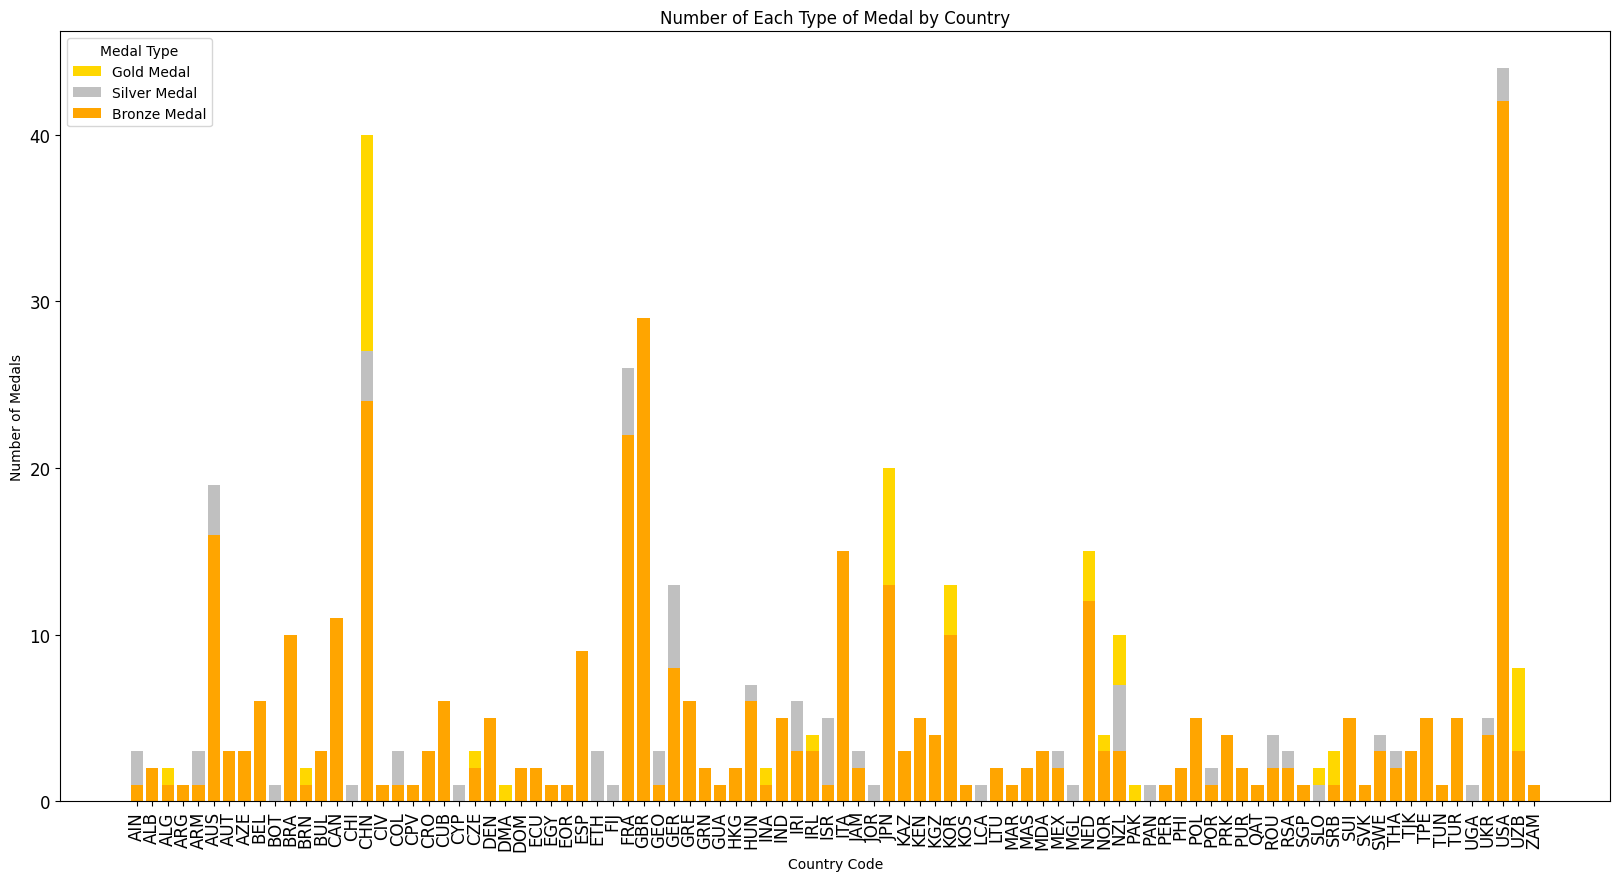

In [210]:
# Melted the pivot table to long format for easier plotting with seaborn
medals_melted = medals_pivot.melt(id_vars='country_code', value_vars=['Gold Medal', 'Silver Medal', 'Bronze Medal'], var_name='medal_type', value_name='medal_count')


# Defined the custom color palette
custom_palette = {
    'Gold Medal': 'gold',
    'Silver Medal': 'silver',
    'Bronze Medal': 'orange'
}

# Ploted the bar chart
plt.figure(figsize=(20, 10))
for medal_type in ['Gold Medal', 'Silver Medal', 'Bronze Medal']:
    subset = medals_melted[medals_melted['medal_type'] == medal_type]
    plt.bar(subset['country_code'], subset['medal_count'], label=medal_type, color=custom_palette[medal_type])
plt.title('Number of Each Type of Medal by Country')
plt.xlabel('Country Code')
plt.ylabel('Number of Medals')
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Medal Type')
plt.show()

In [211]:
from tabulate import tabulate

# Converted the pivot table to a tabular format
medals_table = medals_pivot.reset_index()


In [212]:
medals_df['medal_type'] = medals_df['medal_type'].astype(str)
medals_df['country_code'] = medals_df['country_code'].astype(str)

# Created a pivot table to summarize the number of each type of medal by country
medals_pivot = medals_df.pivot_table(index='country_code', columns='medal_type', aggfunc='size', fill_value=0)

# Added a column for the total number of medals
medals_pivot['Total Medals'] = medals_pivot.sum(axis=1)

# Sorted the table by the total number of medals in descending order
medals_pivot_sorted = medals_pivot.sort_values(by='Total Medals', ascending=False)

# Displayed the table using tabulate for console output
medals_table = medals_pivot_sorted.reset_index()
print(tabulate(medals_table, headers='keys', tablefmt='psql'))



+----+----------------+----------------+--------------+----------------+----------------+
|    | country_code   |   Bronze Medal |   Gold Medal |   Silver Medal |   Total Medals |
|----+----------------+----------------+--------------+----------------+----------------|
|  0 | USA            |             42 |           40 |             44 |            126 |
|  1 | CHN            |             24 |           40 |             27 |             91 |
|  2 | GBR            |             29 |           14 |             22 |             65 |
|  3 | FRA            |             22 |           16 |             26 |             64 |
|  4 | AUS            |             16 |           18 |             19 |             53 |
|  5 | JPN            |             13 |           20 |             12 |             45 |
|  6 | ITA            |             15 |           12 |             13 |             40 |
|  7 | NED            |             12 |           15 |              7 |             34 |
|  8 | GER

## BMI calculate

In [236]:
import pandas as pd
import os

# Load the athletes data
athletes_df = pd.read_csv(os.path.join(general_folder_path, 'athletes.csv'))

# Ensure 'weight' column contains only numeric values
athletes_df['weight'] = pd.to_numeric(athletes_df['weight'], errors='coerce')

# Feature Engineering
# Calculate age from birth_date
athletes_df['birth_date'] = pd.to_datetime(athletes_df['birth_date'])
athletes_df['age'] = (pd.to_datetime('2024-07-27') - athletes_df['birth_date']).dt.days // 365

# Drop rows with '0' or NaN values in 'height' and 'weight' columns
athletes_df = athletes_df[(athletes_df['height'] > 0) & (athletes_df['weight'] > 0)]
athletes_df = athletes_df.dropna(subset=['height', 'weight'])

# Calculate BMI (Body Mass Index)
athletes_df['BMI'] = athletes_df['weight'] / (athletes_df['height']/100)**2

# Select only the required columns
result_df = athletes_df[['name', 'country', 'gender', 'age', 'BMI']]

# Display the first few rows of the result DataFrame
print(result_df.head())

                   name    country gender  age        BMI
370       McNULTY Harry    Ireland   Male   31  28.634039
371        MOLLEN Bryan    Ireland   Male   28  26.035105
372       KENNEDY Terry    Ireland   Male   28  25.082863
431       MONETA Marcos  Argentina   Male   24  21.913806
432  VERA FELD Santiago  Argentina   Male   23  25.029761


In [237]:
import pandas as pd
import os

# Load the athletes data
athletes_df = pd.read_csv(os.path.join(general_folder_path, 'athletes.csv'))

# Ensure 'weight' column contains only numeric values
athletes_df['weight'] = pd.to_numeric(athletes_df['weight'], errors='coerce')

# Feature Engineering
# Calculate age from birth_date
athletes_df['birth_date'] = pd.to_datetime(athletes_df['birth_date'])
athletes_df['age'] = (pd.to_datetime('2024-07-27') - athletes_df['birth_date']).dt.days // 365

# Drop rows with '0' or NaN values in 'height' and 'weight' columns
athletes_df = athletes_df[(athletes_df['height'] > 0) & (athletes_df['weight'] > 0)]
athletes_df = athletes_df.dropna(subset=['height', 'weight'])

# Calculate BMI (Body Mass Index)
athletes_df['BMI'] = athletes_df['weight'] / (athletes_df['height']/100)**2

# Select only the required columns
result_df = athletes_df[['name', 'country', 'gender', 'age', 'BMI']]

# Display the first few rows of the result DataFrame
print(result_df.head())

                   name    country gender  age        BMI
370       McNULTY Harry    Ireland   Male   31  28.634039
371        MOLLEN Bryan    Ireland   Male   28  26.035105
372       KENNEDY Terry    Ireland   Male   28  25.082863
431       MONETA Marcos  Argentina   Male   24  21.913806
432  VERA FELD Santiago  Argentina   Male   23  25.029761


In [235]:
import pandas as pd
import nltk
from textblob import TextBlob
from tabulate import tabulate
import matplotlib.pyplot as plt

# Download necessary NLTK data
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/proxim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [217]:
# Define the paths to the CSV files
athletes_file_path = '/Users/proxim/PROXIM/PROJECTS/olympics2024-analysis/data/CSV_files/general/athletes.csv'
medals_file_path = '/Users/proxim/PROXIM/PROJECTS/olympics2024-analysis/data/CSV_files/general/medals.csv'

# Load CSV files into DataFrames
athletes_df = pd.read_csv(athletes_file_path)
medals_df = pd.read_csv(medals_file_path)

# Ensure 'code' column is of the same type in both DataFrames
athletes_df['code'] = athletes_df['code'].astype(str)
medals_df['code'] = medals_df['code'].astype(str)

# Merge data on 'code' column
merged_df = pd.merge(athletes_df, medals_df, on='code', how='left', suffixes=('_athlete', '_medal'))

# Display the first few rows of the merged DataFrame
print("Merged DataFrame:")
print(merged_df.head())

Merged DataFrame:
      code  current       name_athlete     name_short            name_tv  \
0  1532872     True   ALEKSANYAN Artur   ALEKSANYAN A   Artur ALEKSANYAN   
1  1532873     True     AMOYAN Malkhas       AMOYAN M     Malkhas AMOYAN   
2  1532874     True    GALSTYAN Slavik     GALSTYAN S    Slavik GALSTYAN   
3  1532944     True  HARUTYUNYAN Arsen  HARUTYUNYAN A  Arsen HARUTYUNYAN   
4  1532945     True    TEVANYAN Vazgen     TEVANYAN V    Vazgen TEVANYAN   

  gender_athlete function country_code_athlete country_athlete  \
0           Male  Athlete                  ARM         Armenia   
1           Male  Athlete                  ARM         Armenia   
2           Male  Athlete                  ARM         Armenia   
3           Male  Athlete                  ARM         Armenia   
4           Male  Athlete                  ARM         Armenia   

  country_long_athlete  ...  medal_date        name_medal gender_medal  \
0              Armenia  ...  2024-08-07  Artur ALEKSAN

In [218]:
# Function to get sentiment polarity
def get_sentiment(text):
    if pd.isna(text):
        return None
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply sentiment analysis to the philosophy column
merged_df['philosophy_sentiment'] = merged_df['philosophy'].apply(get_sentiment)

# Categorize sentiment
def categorize_sentiment(polarity):
    if polarity is None:
        return 'Neutral'
    elif polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

merged_df['philosophy_sentiment_category'] = merged_df['philosophy_sentiment'].apply(categorize_sentiment)

# Display the first few rows of the DataFrame with sentiment analysis
print("DataFrame with Sentiment Analysis:")
print(merged_df[['philosophy', 'philosophy_sentiment', 'philosophy_sentiment_category']].head())

DataFrame with Sentiment Analysis:
                                          philosophy  philosophy_sentiment  \
0  "Wrestling is my life." (mediamax.am. 18 May 2...              0.000000   
1  "To become a good athlete, you first have to b...              0.550000   
2                                                NaN                   NaN   
3  “Nothing is impossible, set goals in front of ...             -0.666667   
4                                                NaN                   NaN   

  philosophy_sentiment_category  
0                       Neutral  
1                      Positive  
2                       Neutral  
3                      Negative  
4                       Neutral  


Sentiment vs Medals Analysis:
+---------------------------------+----------+--------+----------+----------------+
| philosophy_sentiment_category   |   Bronze |   Gold |   Silver |   Total Medals |
+=================================+==========+========+==========+================+
| Negative                        |       17 |     10 |       15 |             42 |
+---------------------------------+----------+--------+----------+----------------+
| Neutral                         |      200 |    162 |      171 |            533 |
+---------------------------------+----------+--------+----------+----------------+
| Positive                        |       72 |     63 |       50 |            185 |
+---------------------------------+----------+--------+----------+----------------+

No Medal Analysis:
+----+---------------------------------+------------+
|    | Philosophy Sentiment Category   |   No Medal |
+====+=================================+============+
|  0 | Negative                 

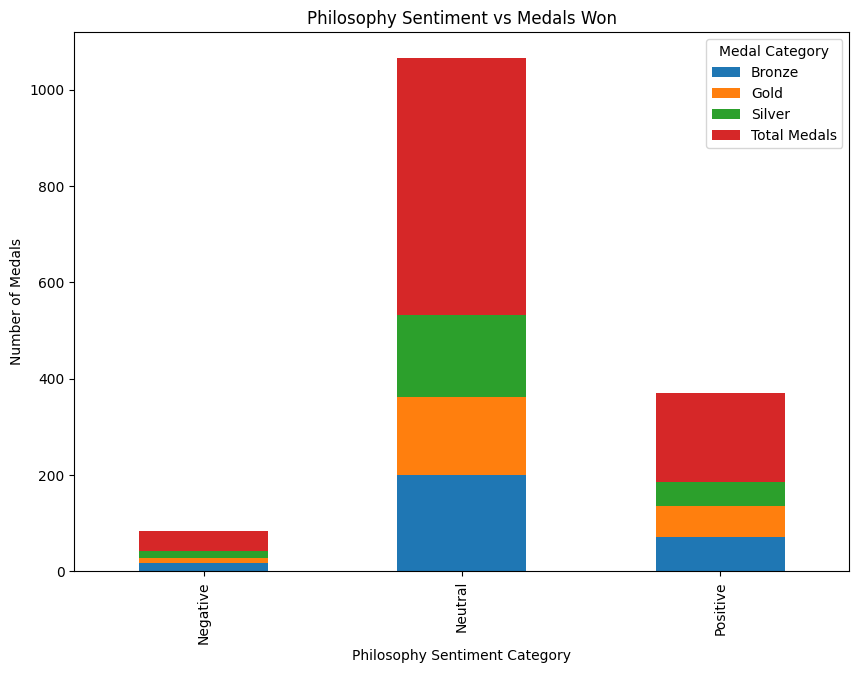

In [219]:
# Function to categorize medals
def categorize_medal(medal_type):
    if medal_type == 'Gold Medal':
        return 'Gold'
    elif medal_type == 'Silver Medal':
        return 'Silver'
    elif medal_type == 'Bronze Medal':
        return 'Bronze'
    else:
        return 'No Medal'

merged_df['medal_category'] = merged_df['medal_type'].apply(categorize_medal)

# Group by sentiment category and medal category
sentiment_medal_analysis = merged_df.groupby(['philosophy_sentiment_category', 'medal_category']).size().unstack(fill_value=0)

# Add a total medal count column
sentiment_medal_analysis['Total Medals'] = sentiment_medal_analysis[['Gold', 'Silver', 'Bronze']].sum(axis=1)

# Separate "No Medal" category
no_medal_analysis = sentiment_medal_analysis['No Medal']
medal_analysis = sentiment_medal_analysis.drop(columns=['No Medal'])

# Display the analysis in table format using tabulate
print("Sentiment vs Medals Analysis:")
print(tabulate(medal_analysis, headers='keys', tablefmt='grid'))

print("\nNo Medal Analysis:")
print(tabulate(no_medal_analysis.reset_index(), headers=['Philosophy Sentiment Category', 'No Medal'], tablefmt='grid'))

# Plot the analysis
medal_analysis.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.xlabel('Philosophy Sentiment Category')
plt.ylabel('Number of Medals')
plt.title('Philosophy Sentiment vs Medals Won')
plt.legend(title='Medal Category')
plt.show()

In [220]:
import sqlite3

# Connect to the SQLite database
connection = sqlite3.connect('data/general.db')

# Save the merged DataFrame to the SQLite database
merged_df.to_sql('athletes_medals_sentiment', connection, if_exists='replace', index=False)

# Close the connection
connection.close()

In [221]:
# Connect to the SQLite database
connection = sqlite3.connect('data/general.db')

# Load the merged DataFrame from the SQLite database
merged_df = pd.read_sql_query("SELECT * FROM athletes_medals_sentiment", connection)

# Close the connection
connection.close()

# Display the first few rows of the merged DataFrame
merged_df.head()

,code,current,name_athlete,name_short,name_tv,gender_athlete,function,country_code_athlete,country_athlete,country_long_athlete,...,discipline,event,event_type,url_event,country_code_medal,country_medal,country_long_medal,philosophy_sentiment,philosophy_sentiment_category,medal_category
0,1532872,1,ALEKSANYAN Artur,ALEKSANYAN A,Artur ALEKSANYAN,Male,Athlete,ARM,Armenia,Armenia,...,Wrestling,Men's Greco-Roman 97kg,HATH,/en/paris-2024/results/wrestling/men-s-greco-r...,ARM,Armenia,Armenia,0.000000,Neutral,Silver
1,1532873,1,AMOYAN Malkhas,AMOYAN M,Malkhas AMOYAN,Male,Athlete,ARM,Armenia,Armenia,...,Wrestling,Men's Greco-Roman 77kg,HATH,/en/paris-2024/results/wrestling/men-s-greco-r...,ARM,Armenia,Armenia,0.550000,Positive,Bronze
2,1532874,1,GALSTYAN Slavik,GALSTYAN S,Slavik GALSTYAN,Male,Athlete,ARM,Armenia,Armenia,...,None,None,None,None,None,None,None,NaN,Neutral,No Medal
3,1532944,1,HARUTYUNYAN Arsen,HARUTYUNYAN A,Arsen HARUTYUNYAN,Male,Athlete,ARM,Armenia,Armenia,...,None,None,None,None,None,None,None,-0.666667,Negative,No Medal
4,1532945,1,TEVANYAN Vazgen,TEVANYAN V,Vazgen TEVANYAN,Male,Athlete,ARM,Armenia,Armenia,...,None,None,None,None,None,None,None,NaN,Neutral,No Medal


In [222]:
# Function to categorize hobbies
def categorize_hobbies(hobby):
    if pd.isna(hobby):
        return 'Unknown'
    hobby = hobby.lower()
    if 'football' in hobby or 'soccer' in hobby:
        return 'Football/Soccer'
    elif 'music' in hobby or 'singing' in hobby:
        return 'Music'
    elif 'reading' in hobby or 'books' in hobby:
        return 'Reading'
    elif 'swimming' in hobby:
        return 'Swimming'
    elif 'running' in hobby or 'jogging' in hobby:
        return 'Running'
    elif 'watching movies' in hobby or 'movies' in hobby:
        return 'Movies'
    elif 'travel' in hobby:
        return 'Travel'
    else:
        return 'Other'

# Apply the function to categorize hobbies
merged_df['hobby_category'] = merged_df['hobbies'].apply(categorize_hobbies)

# Display the first few rows of the DataFrame with categorized hobbies
print("DataFrame with Categorized Hobbies:")
print(merged_df[['hobbies', 'hobby_category']].head())

DataFrame with Categorized Hobbies:
                         hobbies   hobby_category
0  Playing and watching football  Football/Soccer
1                           None          Unknown
2                           None          Unknown
3                           None          Unknown
4                           None          Unknown



No Medal Analysis:
+----+------------------+------------+
|    | Hobby Category   |   No Medal |
+====+==================+============+
|  0 | Football/Soccer  |        328 |
+----+------------------+------------+
|  1 | Movies           |        121 |
+----+------------------+------------+
|  2 | Music            |        565 |
+----+------------------+------------+
|  3 | Other            |       1973 |
+----+------------------+------------+
|  4 | Reading          |        520 |
+----+------------------+------------+
|  5 | Running          |         56 |
+----+------------------+------------+
|  6 | Swimming         |         66 |
+----+------------------+------------+
|  7 | Travel           |        204 |
+----+------------------+------------+
|  8 | Unknown          |       6572 |
+----+------------------+------------+
Hobbies vs Medals Analysis:
+------------------+----------+--------+----------+----------------+
| hobby_category   |   Bronze |   Gold |   Silver |   Total Meda

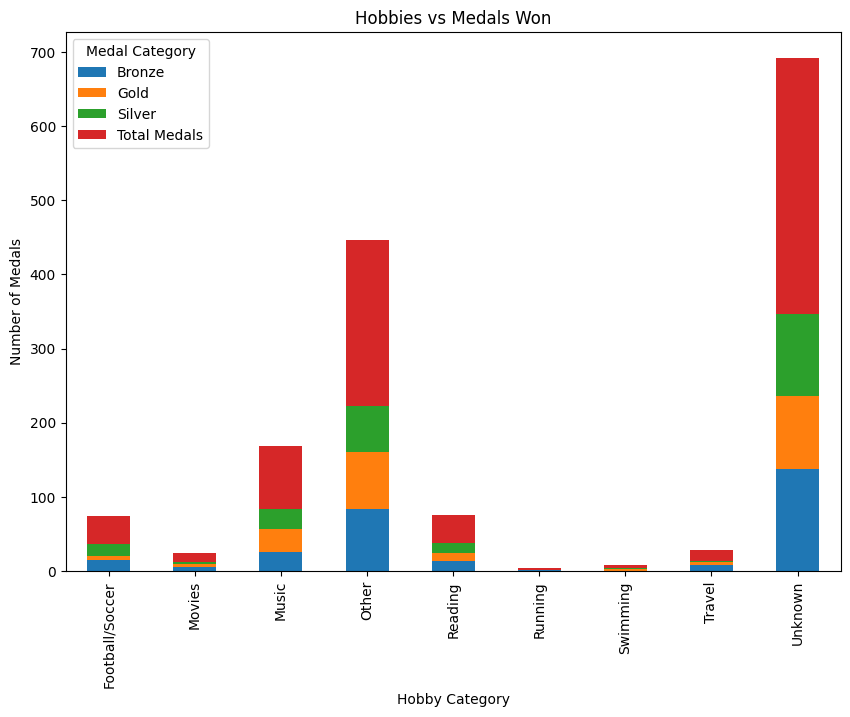

In [223]:
# Function to categorize medals
def categorize_medal(medal_type):
    if medal_type == 'Gold Medal':
        return 'Gold'
    elif medal_type == 'Silver Medal':
        return 'Silver'
    elif medal_type == 'Bronze Medal':
        return 'Bronze'
    else:
        return 'No Medal'

merged_df['medal_category'] = merged_df['medal_type'].apply(categorize_medal)

# Group by hobby category and medal category
hobby_medal_analysis = merged_df.groupby(['hobby_category', 'medal_category']).size().unstack(fill_value=0)

# Add a total medal count column
hobby_medal_analysis['Total Medals'] = hobby_medal_analysis[['Gold', 'Silver', 'Bronze']].sum(axis=1)

# Check if "No Medal" column exists
if 'No Medal' in hobby_medal_analysis.columns:
    # Separate "No Medal" category
    no_medal_analysis = hobby_medal_analysis['No Medal']
    medal_analysis = hobby_medal_analysis.drop(columns=['No Medal'])

    print("\nNo Medal Analysis:")
    print(tabulate(no_medal_analysis.reset_index(), headers=['Hobby Category', 'No Medal'], tablefmt='grid'))
else:
    medal_analysis = hobby_medal_analysis

# Display the analysis in table format using tabulate
print("Hobbies vs Medals Analysis:")
print(tabulate(medal_analysis, headers='keys', tablefmt='grid'))

# Plot the analysis
medal_analysis.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.xlabel('Hobby Category')
plt.ylabel('Number of Medals')
plt.title('Hobbies vs Medals Won')
plt.legend(title='Medal Category')
plt.show()